In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import Wave2WaveV1
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from deepseries.analysis import SeriesAnalysisModel
import deepseries.functional as F
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
import tqdm
import typing

plt.style.use("ggplot")

In [2]:
power = pd.read_csv('../data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p)

In [3]:
power_day = power.T.resample("D").mean().T

In [4]:
analysis = SeriesAnalysisModel(power_day.values, mask_zero=True)

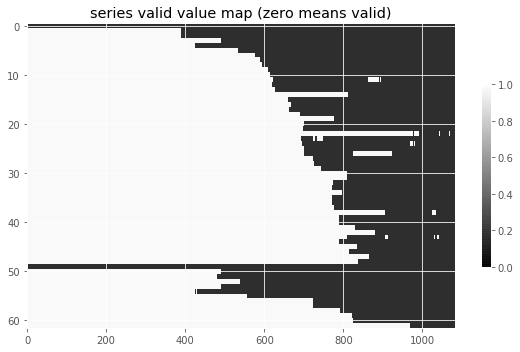

In [5]:
analysis.plot_valid()

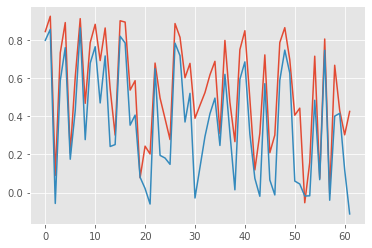

In [37]:
plt.plot(analysis.autocorr[:, 7])
plt.plot(analysis.autocorr[:, 14])

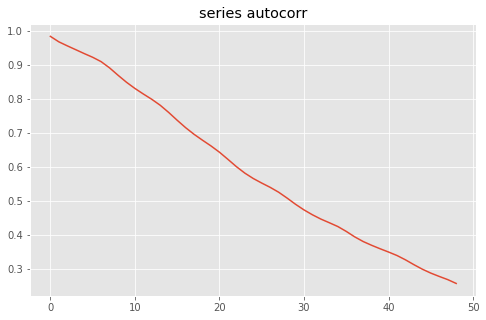

In [44]:
analysis.plot_autocorr(4)

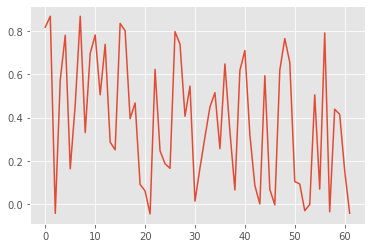

In [46]:
plt.plot(analysis.autocorr[:, 13])

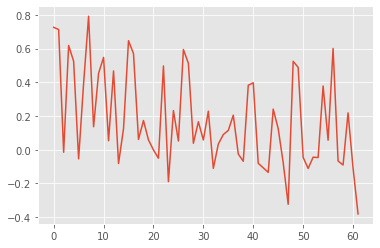

In [50]:
plt.plot(analysis.autocorr[:, 27])

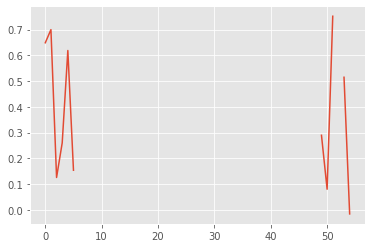

In [49]:
plt.plot(analysis.autocorr[:, 364])

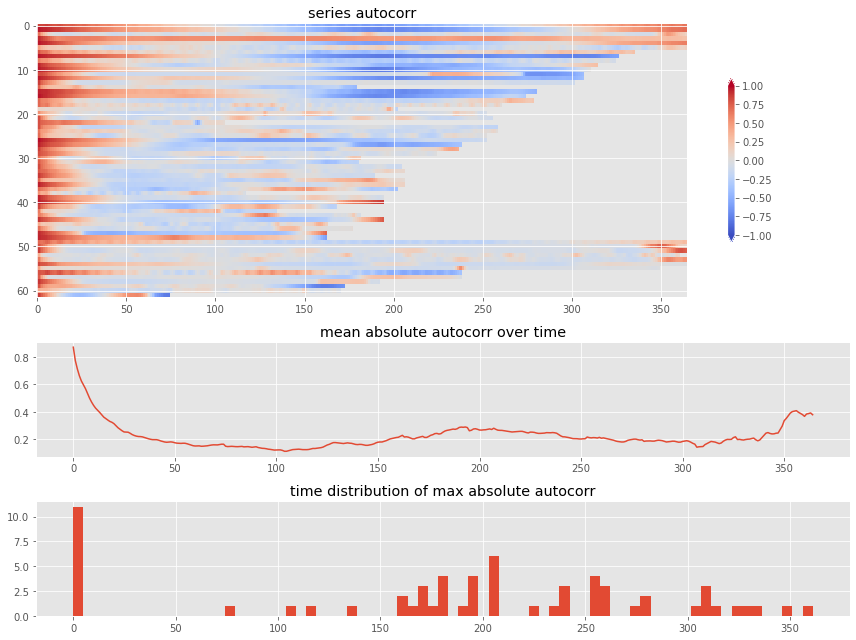

In [48]:
analysis.get_autocorr(np.arange(1, 366), use_smooth=True).plot_autocorr(figsize=(12, 9))

In [20]:
np.argmax(np.abs(analysis.autocorr), 1)

array([5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0], dtype=int64)

In [16]:
analysis.autocorr.shape

(62, 49)

In [ ]:
sns.countplot()

<BarContainer object of 62 artists>

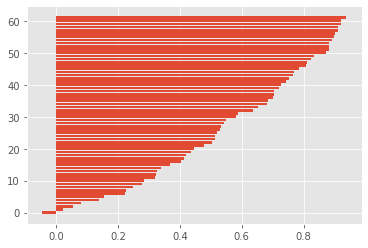

In [7]:
plt.barh(np.arange(62), np.sort(analysis.autocorr[:, 6]))

<BarContainer object of 62 artists>

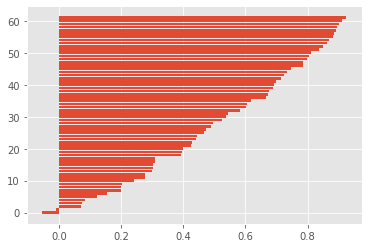

In [8]:
plt.barh(np.arange(62), np.sort(analysis.autocorr[:, 7]))

In [9]:
analysis.autocorr.mean(0)

array([0.87136838, 0.77323932, 0.70804094, 0.66029198, 0.62047438,
       0.59435016, 0.57131429, 0.53113946, 0.49476161, 0.46828472,
       0.44242323, 0.41962109, 0.40538493, 0.39117311, 0.3652536 ,
       0.34055156, 0.32187459, 0.30825082, 0.29524422, 0.28676209,
       0.28069582, 0.25842923, 0.23829978, 0.22392747, 0.20917519,
       0.1959408 , 0.1885049 , 0.18103279, 0.16364905, 0.14577447,
       0.13412108, 0.12601529, 0.1207369 , 0.122197  , 0.12446993,
       0.11313436, 0.09906246, 0.08908089, 0.08394725, 0.07953642,
       0.08020735, 0.08130702, 0.06857408, 0.05642683, 0.05094818,
       0.04797187, 0.04510662, 0.04660661, 0.04754263])

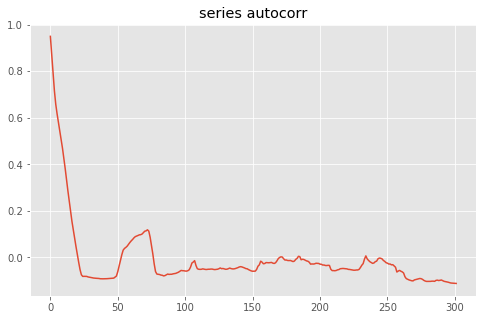

In [17]:
analysis.plot_autocorr(13)

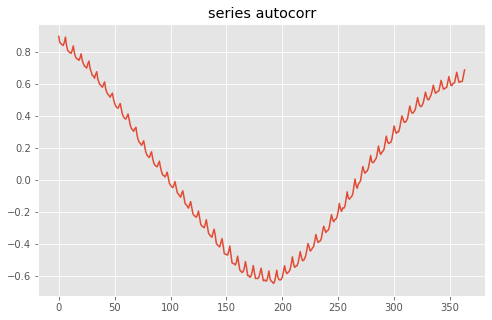

In [18]:
analysis.plot_autocorr(0)

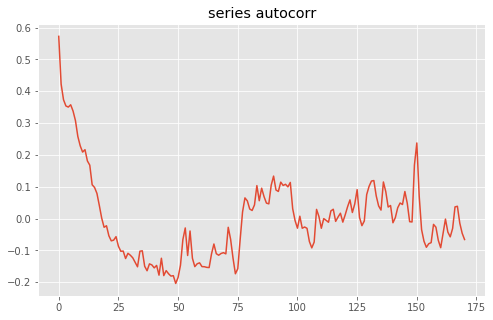

In [19]:
analysis.plot_autocorr(60)

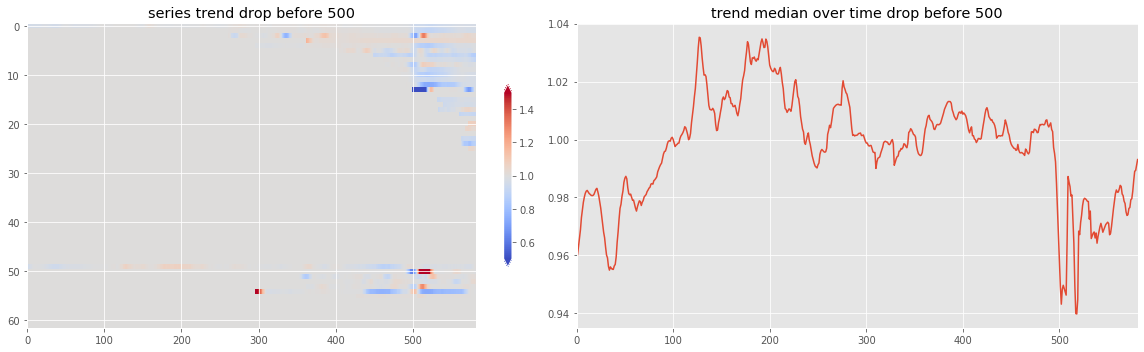

In [25]:
analysis.get_trend(max_T=365, use_smooth=True, smooth_windows=11, smooth_ratio=0.9).plot_trend(drop_before=500, figsize=(16, 5))
plt.tight_layout()

In [9]:
analysis.trend